# Getting started: import required modules

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import netCDF4
from difflib import SequenceMatcher
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

## Load some colormaps (if needed):

cmap_dirs = [x for x in os.listdir('/home/leachl/Downloads/ScientificColourMaps5/') if not '.' in x and not '+' in x]
cmaps = {}
for cmapname in cmap_dirs:
    cm_data = np.loadtxt('/home/leachl/Downloads/ScientificColourMaps5/'+cmapname+'/'+cmapname+'.txt')
    cmaps[cmapname] = matplotlib.colors.LinearSegmentedColormap.from_list(cmapname, cm_data)

# Running GIR

### 1. Create GIR compatible inputs

- GIR uses a multi-index pandas dataframe structure for its input. These are largely identical to normal dataframes, but with some added nuances to using them properly.
- It uses this structure to require users to keep track of the scenarios they wish to run.
- Most of the default functions created for FaIR v2.0 are for simulating the three major GHGs: CO2, CH4 and N2O.

#### Emission and forcing inputs

In [2]:
# The following function returns an empty dataframe in the correct format for use in GIR.

test_emissions = return_empty_emissions(df_to_copy=False, start_year=0, end_year=100, timestep=1, scen_names=['Test'], gases_in = ['CO2','CH4','N2O'])

# Although here we demonstrate using GIR in emissions driven mode, an identical format dataframe is used for concentrations driven mode.

# create an empty forcing dataframe compatible with test_emissions:

test_forcing = return_empty_forcing(test_emissions)

# Note that the scenario names in the emissions and forcing dataframe must be identical for the model to run: GIR assumes each emissions scenario corresponds directly to a single forcing scenario.

test_emissions.head()

Scenario Test        
Gas       CO2 CH4 N2O
Year                 
0.0         0   0   0
1.0         0   0   0
2.0         0   0   0
3.0         0   0   0
4.0         0   0   0

In [3]:
# Although these functions have been created for ease of use, to create a compatible dataframe from scratch, use the following commands:

empty_array = np.zeros(101)

test_emissions = pd.DataFrame({'CO2':empty_array,'CH4':empty_array,'N2O':empty_array},index= np.arange(101))
test_emissions = pd.concat([test_emissions],keys=['Test'],axis=1)

#### Parameter inputs

- If these are not provided, FaIR will automatically use its default parameters

In [4]:
# Generate a default parameter dataframe:

test_gas_parameters = get_gas_parameter_defaults()

test_thermal_parameters = get_thermal_parameter_defaults()

# This is what the parameter dataframes look like:
test_gas_parameters

default                        
Gas                    CO2         CH4         N2O
param_name                                        
a1                0.217300    1.000000    1.000000
a2                0.224000    0.000000    0.000000
a3                0.282400    0.000000    0.000000
a4                0.276300    0.000000    0.000000
tau1        1000000.000000    9.150000  116.000000
tau2            394.400000    1.000000    1.000000
tau3             36.540000    1.000000    1.000000
tau4              4.304000    1.000000    1.000000
r0               28.627296    9.078874   67.843356
rC                0.019773    0.000000    0.000000
rT                4.334433   -0.287247    0.000000
rA                0.000000    0.000343   -0.000999
PI_conc         278.000000  733.822081  271.258492
emis2conc         0.468952    0.351714    0.200980
f1                5.754389    0.061736   -0.054407
f2                0.001215   -0.000049    0.000157
f3               -0.069598    0.038416    0.106208

In [5]:
test_thermal_parameters

Thermal_param_set     default                 
Box                         1         2      3
param_name                                    
d                  283.000000  9.880000  0.850
q                    0.311333  0.165417  0.242

In [6]:
# This allows you to check the parameters for any of the species listed above (which include some aerosols)

get_gas_parameter_defaults(['C8F18']).T

,param_name,a1,a2,a3,a4,tau1,tau2,tau3,tau4,r0,rC,rT,rA,PI_conc,emis2conc,f1,f2,f3
,Gas,,,,,,,,,,,,,,,,,
default,C8F18,1.0,0.0,0.0,0.0,150.0,1.0,1.0,1.0,137.806762,0.0,0.0,0.0,1.000000e-30,0.012846,0.0,0.55,0.0


In [7]:
# One useful function for checking thermal parameter sensitivities is q_to_tcr_ecs(), which returns the corresponding ECS and TCR values:

q_to_tcr_ecs(test_thermal_parameters)

Thermal_param_set,default
ECS,2.76
TCR,1.60


### 2. Running GIR

In [8]:
# Let's carry out a few basic runs now, starting with pulse emissions for each gas.

# First generate an empty emissions dataframe with four different scenarios

pulse_emissions = return_empty_emissions(df_to_copy=False, start_year=0, end_year=100, timestep=1, scen_names=['None']+[x+'pulse' for x in ['CO2','CH4','N2O']], gases_in = ['CO2','CH4','N2O'])

# add pulses in year 10 (the units are GtC, MtCH4 and MtN2O-N2):

for gas in ['CO2','CH4','N2O']:
    
    pulse_emissions.loc[10,(gas+'pulse',gas)] += 10
    
# Now generate a compatible forcing dataframe:

pulse_forcing = return_empty_forcing(pulse_emissions)

# And run the model!

pulse_run = run_GIR(emissions_in=pulse_emissions,forcing_in=pulse_forcing,gas_parameters=test_gas_parameters,thermal_parameters=test_thermal_parameters)

Integrating 4 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 100.0...


In [9]:
# GIR outputs a dictionary of the variables it diagnoses on each run:

print('Diagnosed variables:',list(pulse_run.keys()))

Diagnosed variables: ['C', 'RF', 'T', 'alpha', 'Emissions', 'gas_parameters', 'thermal parameters']


In [10]:
# For example, let's look at the simulated concentrations from GIR:

# GIR keeps track in the dataframe of exactly which scenario, gas parameters and thermal parameters correspond to in the output:

pulse_run['C'].head()

Scenario      CH4pulse                         CO2pulse              \
Parameter set  default                          default               
Gas name           CO2         CH4         N2O      CO2         CH4   
Year                                                                  
0.0              278.0  733.822081  271.258492    278.0  733.822081   
1.0              278.0  733.822081  271.258492    278.0  733.822081   
2.0              278.0  733.822081  271.258492    278.0  733.822081   
3.0              278.0  733.822081  271.258492    278.0  733.822081   
4.0              278.0  733.822081  271.258492    278.0  733.822081   

Scenario                  N2Opulse                            None  \
Parameter set              default                         default   
Gas name              N2O      CO2         CH4         N2O     CO2   
Year                                                                 
0.0            271.258492    278.0  733.822081  271.258492   278.0   
1.0            271.258492    278.0  733.822081  271.258492   278.0   
2.0            271.258492    278.0  733.822081  271.258492   278.0   
3.0            271.258492    278.0  733.822081  271.258492   278.0   
4.0            271.258492    278.0  733.822081  271.258492   278.0   

Scenario                               
Parameter set                          
Gas name              CH4         N2O  
Year                                   
0.0            733.822081  271.258492  
1.0            733.822081  271.258492  
2.0            733.822081  271.258492  
3.0            733.822081  271.258492  
4.0            733.822081  271.258492

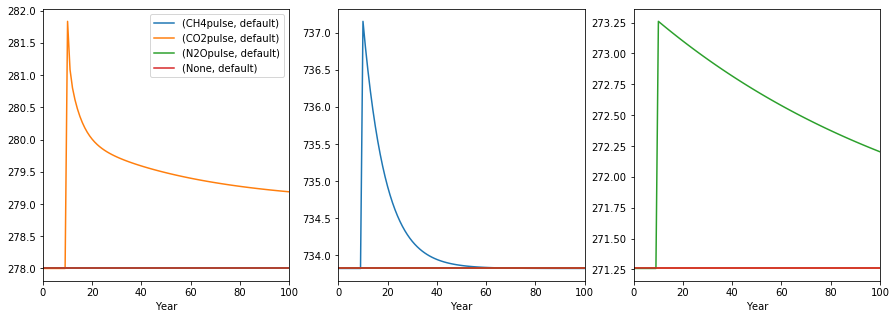

In [11]:
# Example of plotting the various scenarios against one another (also note .xs, a very handy pandas function for multi-index dataframes):

fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    pulse_run['C'].xs(gas,level=-1,axis=1).plot(ax=ax[i],legend=False)
    
ax[0].legend()

### Other "modes" GIR has

- GIR can also carry out forcing-only runs, and concentration driven runs, as follows:

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 100.0...


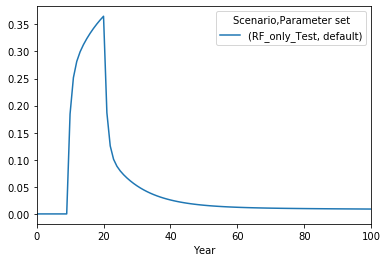

In [12]:
# A forcing-only run

RF_only_test = return_empty_forcing(start_year=0,end_year=100,scen_names=['RF_only_Test'])

## let's try a step change in RF

RF_only_test.loc[10:20]=1

RF_only_results = run_GIR(emissions_in=return_empty_emissions(RF_only_test),forcing_in=RF_only_test)

RF_only_results['T'].plot()

In [13]:
# A concentration-only run

## The main bit to remember here is that GIR is baselined at the pre-industrial concentration values!

## Let's try a 1%/yr scenario for each gas:
concentration_only_test = return_empty_emissions(df_to_copy=False, start_year=0, end_year=160, timestep=1, scen_names=[x+'_1%' for x in ['CO2','CH4','N2O']], gases_in = ['CO2','CH4','N2O'])

# Baseline to pre-industrial values 
# start a 1%/yr increase in year 10
for gas in ['CO2','CH4','N2O']:
    
    concentration_only_test.loc[:,(slice(None),gas)] = get_gas_parameter_defaults().copy().loc['PI_conc',('default',gas)]
    
    concentration_only_test.loc[10:,(gas+'_1%',gas)] = concentration_only_test.loc[10,(gas+'_1%',gas)] * 1.01 ** (concentration_only_test.loc[10:].index-concentration_only_test.loc[10:].index[0])

# Run the experiment:

concentration_only_test_results = run_GIR(concentrations_in=concentration_only_test,forcing_in=return_empty_forcing(concentration_only_test))

Integrating 3 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 160.0...


Text(0.5, 1.0, '1%/yr concentration increase temperatures')

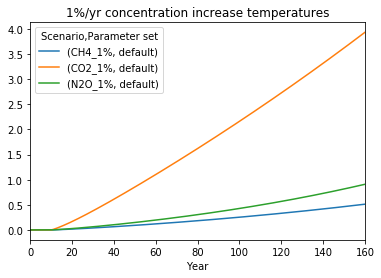

In [14]:
concentration_only_test_results['T'].plot()
plt.title('1%/yr concentration increase temperatures')

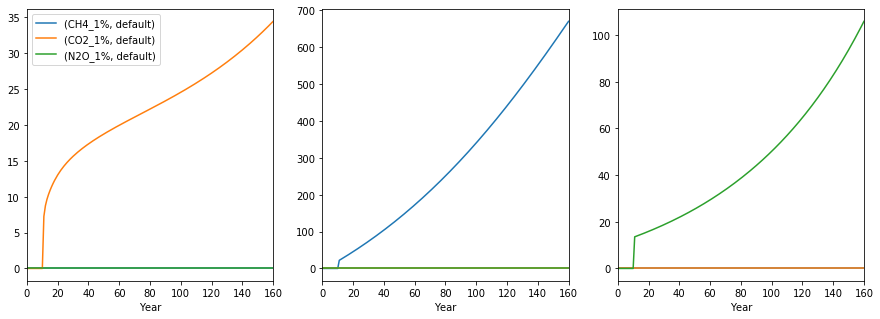

In [15]:
# By default, when a concentration run is carried out, GIR diagnoses the corresponding emissions required to obtain those concentrations:

fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    concentration_only_test_results['Emissions'].xs(gas,level=-1,axis=1).plot(ax=ax[i],legend=False)
    
ax[0].legend()

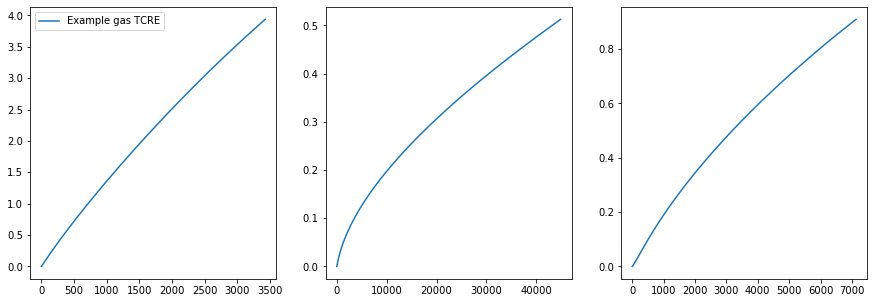

In [16]:
# Example TCRE plot

fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,gas in enumerate(['CO2','CH4','N2O']):
    
    ax[i].plot(concentration_only_test_results['Emissions'][gas+'_1%'].xs(gas,level=-1,axis=1).cumsum(),concentration_only_test_results['T'][gas+'_1%'],label='Example gas TCRE')
    
ax[0].legend()

# Other useful features: variable timestepping, parameter ensembles, additional gases, blended runmodes

- GIR can run with any length timestep desired: it takes the timestep sizes from the dataframe index (and can therefore also run with non-constant timesteps if desired).
- Due to its delibarately parallel formulation, GIR is designed to run parameter ensembles quickly, done by simply joining parameter dataframes in a manner identical to the emissions dataframes. This can be sped up further through python's multiprocessing module.
- Though intended for use with the three major gases, GIR can run any number of additional gases if desired.

### Variable timestepping:

In [17]:
## As an example, let's run a block emission and increase the temporal resolution only around the block edges

df_index = np.concatenate((np.arange(9),np.arange(9,15,0.1),np.arange(15,45),np.arange(45,51,0.1),np.arange(51,100)))

test_var_timestep_0 = pd.concat([pd.DataFrame(index=df_index,columns=['CO2','CH4','N2O'])],keys=['var_dt'],axis=1).fillna(0.0)

test_var_timestep_0.loc[10:50,('var_dt','CO2')] = 10 * np.diff(test_var_timestep_0.loc[9.9:50].index)

test_var_timestep_1 = return_empty_emissions(start_year=0,end_year=99,scen_names=['const_dt'])

test_var_timestep_1.loc[10:50,('const_dt','CO2')] = 10

var_timestep_results = run_GIR(emissions_in=test_var_timestep_0)
const_timestep_results = run_GIR(emissions_in=test_var_timestep_1)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 99.0...
Integrating 1 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 99.0...


Lower response in the longer timestep is since emissions in year t are simulated as though they are put in between t-1 and t.
Hence longer timestep emissions are over 9->10 whereas shorter are over 9.9->10 so cumulative carbon emissions differ.


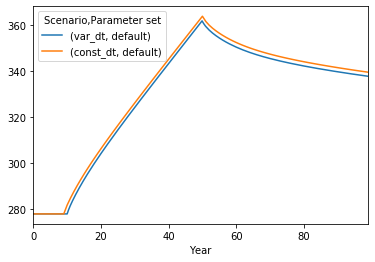

In [18]:
fig,ax=plt.subplots()
var_timestep_results['C'].xs('CO2',level=-1,axis=1).plot(ax=ax)
const_timestep_results['C'].xs('CO2',level=-1,axis=1).plot(ax=ax)

print('Lower response in the longer timestep is since emissions in year t are simulated as though they are put in between t-1 and t.')
print('Hence longer timestep emissions are over 9->10 whereas shorter are over 9.9->10 so cumulative carbon emissions differ.')

### Parameter Ensembles:

In [19]:
# First we generate a thermal parameter ensemble based on inferred parameter ranges and dependencies from a 3-box CMIP6 emulation

thermal_param_set = get_more_thermal_params(200)

gas_cycle_param_set = get_more_gas_cycle_params(100)

print('Structure of parameter ensembles:')
print()
print(gas_cycle_param_set.head())
print()
print(thermal_param_set)

Structure of parameter ensembles:

                    gas0                               gas1            \
Gas                  CO2      CH4         N2O           CO2       CH4   
param_name                                                              
a1                0.2173  1.00000    1.000000        0.2173  1.000000   
a2                0.2240  0.00000    0.000000        0.2240  0.000000   
a3                0.2824  0.00000    0.000000        0.2824  0.000000   
a4                0.2763  0.00000    0.000000        0.2763  0.000000   
tau1        1000000.0000  9.84857  114.951156  1000000.0000  9.428789   

                                gas2                               gas3  ...  \
Gas                N2O           CO2       CH4        N2O           CO2  ...   
param_name                                                               ...   
a1            1.000000        0.2173  1.000000    1.00000        0.2173  ...   
a2            0.000000        0.2240  0.000000    0.00000   

In [20]:
## Run the model:
start = time.time()
parameter_ensemble_run = run_GIR(emissions_in=pulse_emissions,forcing_in=pulse_forcing,gas_parameters=gas_cycle_param_set,thermal_parameters=thermal_param_set)
print('Runtime:',time.time()-start)

Integrating 4 scenarios, 100 gas cycle parameter sets, 200 independent thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 100.0...
Runtime: 8.64410400390625


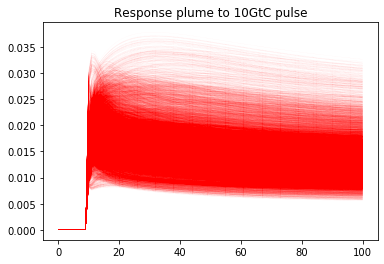

In [21]:
plt.plot(parameter_ensemble_run['T']['CO2pulse'],label=   '',linewidth=0.01,color='r')
plt.title('Response plume to 10GtC pulse')
print()

In [22]:
## Can we speed this up with multiprocessing? Eg by parallellising cpu useage over the thermal parameter dimension? (Yes, by a factor of ~ 0.3-0.5)

from multiprocessing import Pool

thermal_param_sets = []
    
for thermal_param_name in thermal_param_set.columns.levels[0]:
        
    thermal_param_sets += [pd.concat([thermal_param_set[thermal_param_name]],keys=[thermal_param_name],axis=1)]

def use_multiprocessing(thermal_params):
    
    return run_GIR(emissions_in=pulse_emissions,forcing_in=pulse_forcing,gas_parameters=gas_cycle_param_set,thermal_parameters=thermal_params,show_run_info=False)

cpu_pool = Pool(processes=10)

start_time = time.time()
mp_results = cpu_pool.map(use_multiprocessing, thermal_param_sets)
print('Runtime:',time.time()-start_time)

Runtime: 3.083869695663452


### Additional gases:

- NB. If you generate two parameter ensembles that are intended to be fully dependent (ie. gas set 1 => thermal set 1 etc.), make the set names identical and GIR runs in parameter dependent mode

In [23]:
# FaIR is capable of running with any number of gases, the full tuned parameter set is saved here:

FULL_gas_cycle_params = get_gas_parameter_defaults(['BC', 'C2F6', 'C3F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'CCl4', 'CF4', 'CFC-11', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-12', 'CH2Cl2', 'CH3Br', 'CH3CCl3', 'CH3Cl', 'CH4', 'CHCl3', 'CO', 'CO2', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2402', 'N2O', 'NF3', 'NH3', 'NMVOC', 'NOx', 'OC', 'SF6', 'SO2F2', 'SOx', 'c-C4F8'])

## NB units for all other gases are ppb & Mt

## The full gas suite parameter set is below:
FULL_gas_cycle_params

default                                            \
Gas                   BC          C2F6          C3F8         C4F10   
param_name                                                           
a1          1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
a2          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
a3          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
a4          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
tau1        1.000000e+00  5.000000e+02  1.300000e+02  1.300000e+02   
tau2        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
tau3        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
tau4        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
r0          1.000000e+00  1.168819e+02  1.398766e+02  1.398766e+02   
rC          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
rT          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
rA          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
PI_conc     1.000000e-30  1.000000e-30  1.000000e-30  1.000000e-30   
emis2conc   1.000000e+00  4.077551e-02  2.992994e-02  2.364168e-02   
f1          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
f2          5.069204e-02  2.500000e-01  2.800000e-01  3.600000e-01   
f3          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                                                                               \
Gas                C5F12         C6F14         C7F16         C8F18       CCl4   
param_name                                                                      
a1          1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000   
a2          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
a3          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
a4          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
tau1        2.050000e+02  1.550000e+02  1.500000e+02  1.500000e+02  34.423828   
tau2        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000   
tau3        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000   
tau4        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   1.000000   
r0          1.322726e+02  1.372772e+02  1.378068e+02  1.378068e+02  32.539098   
rC          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
rT          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
rA          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
PI_conc     1.000000e-30  1.000000e-30  1.000000e-30  1.000000e-30   0.000025   
emis2conc   1.953765e-02  1.664713e-02  1.450181e-02  1.284625e-02   0.036587   
f1          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   
f2          4.100000e-01  4.400000e-01  5.000000e-01  5.500000e-01   0.170000   
f3          0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000   

                         ...                                          \
Gas                 CF4  ...         N2O           NF3           NH3   
param_name               ...                                           
a1             1.000000  ...    1.000000  1.000000e+00  1.000000e+00   
a2             0.000000  ...    0.000000  0.000000e+00  0.000000e+00   
a3             0.000000  ...    0.000000  0.000000e+00  0.000000e+00   
a4             0.000000  ...    0.000000  0.000000e+00  0.000000e+00   
tau1        2500.000000  ...  116.000000  1.633167e+03  1.000000e+00   
tau2           1.000000  ...    1.000000  1.000000e+00  1.000000e+00   
tau3           1.000000  ...    1.000000  1.000000e+00  1.000000e+00   
tau4           1.000000  ...    1.000000  1.000000e+00  1.000000e+00   
r0           103.860466  ...   67.843356  9.700000e+01  1.000000e+00   
rC             0.000000  ...    0.000000  0.000000e+00  0.000000e+00   
rT             0.000000  ...    0.000000  0.000000e+00  0.0

In [24]:
FULL_gas_emissions = return_empty_emissions(start_year=0,end_year=100,gases_in=FULL_gas_cycle_params.columns.levels[-1])

# pulse emission of 10 units in year 10 for each gas

FULL_gas_emissions .loc[10,:] = 10

FULL_gas_forcing = return_empty_forcing(FULL_gas_emissions)

FULL_gas_results = run_GIR(emissions_in=FULL_gas_emissions,forcing_in=FULL_gas_forcing,gas_parameters=FULL_gas_cycle_params)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['BC', 'C2F6', 'C3F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'CCl4', 'CF4', 'CFC-11', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-12', 'CH2Cl2', 'CH3Br', 'CH3CCl3', 'CH3Cl', 'CH4', 'CHCl3', 'CO', 'CO2', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2402', 'N2O', 'NF3', 'NH3', 'NMVOC', 'NOx', 'OC', 'SF6', 'SO2F2', 'SOx', 'c-C4F8'], between 0.0 and 100.0...


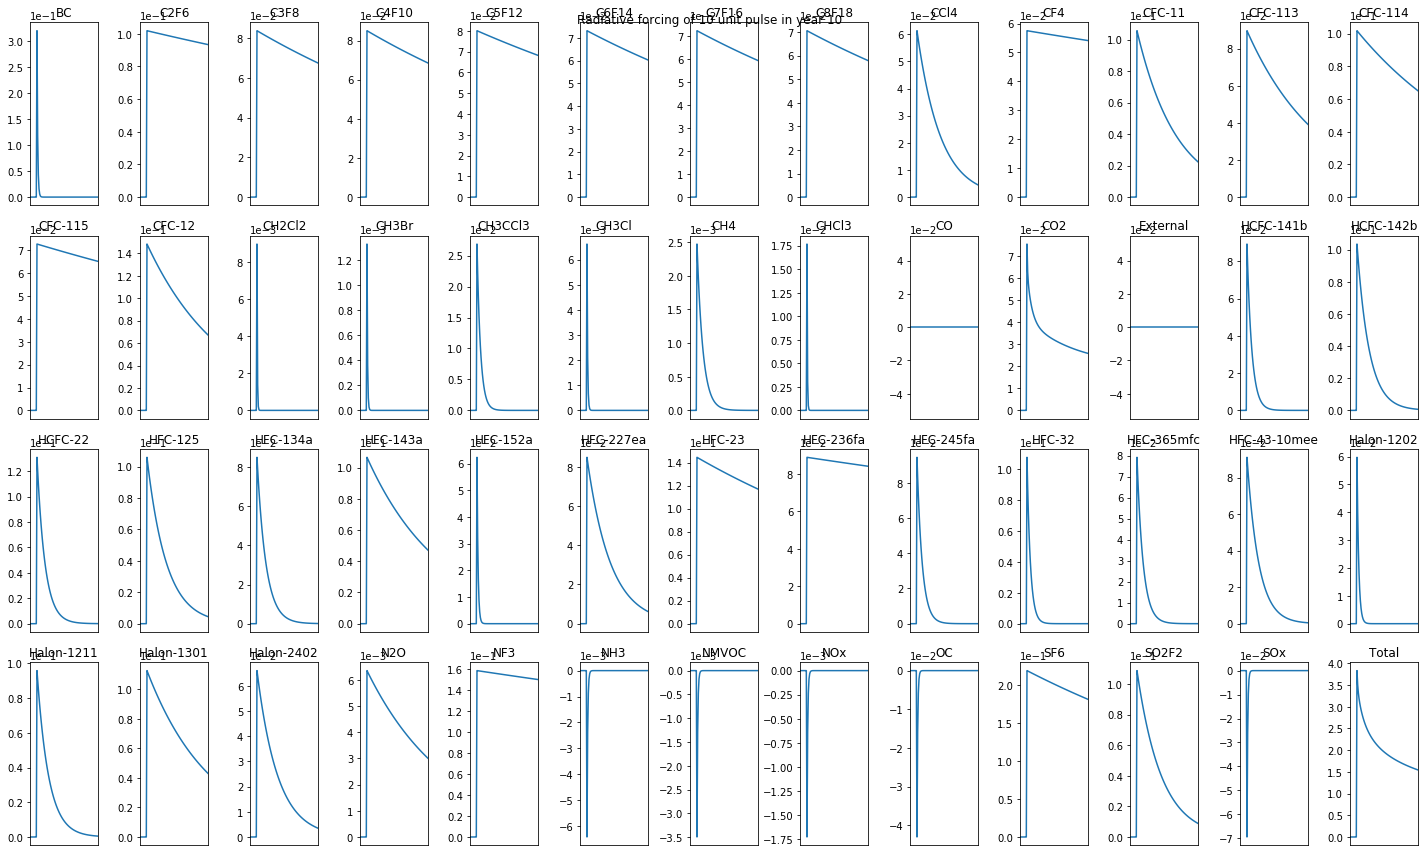

In [25]:
fig,ax = plt.subplots(4,13,figsize=(20,12))

for i,gas in enumerate(FULL_gas_results['RF'].columns.levels[-1][:-1]):
    
    FULL_gas_results['RF'].xs(gas,level=-1,axis=1).plot(ax=ax.flatten()[i],legend=None)
    ax.flatten()[i].set_title(gas)
    ax.flatten()[i].set_xlabel('')
    ax.flatten()[i].set_xticks([])
    ax.flatten()[i].ticklabel_format(axis='y', style='sci',scilimits=(0,1))
    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Radiative forcing of 10 unit pulse in year 10')
plt.tight_layout()

In [26]:
## We can also run a single gas (which actually leads to very little speed benfit due to the parallel model nature)

start = time.time()
FULL_gas_results = run_GIR(emissions_in=FULL_gas_emissions,forcing_in=FULL_gas_forcing,gas_parameters=FULL_gas_cycle_params)
print('51 gas run time:',time.time()-start,'s')

## NB. The .reindex(list,axis=,level=) function is EXTREMELY useful for obtaining subsets of parameter/emission arrays

ONE_gas_emission = FULL_gas_emissions.reindex(['CFC-12'],axis=1,level=1)
ONE_gas_forcing = return_empty_forcing(ONE_gas_emission)
ONE_gas_params = FULL_gas_cycle_params.reindex(['CFC-12'],axis=1,level=1)

start = time.time()
ONE_gas_results = run_GIR(emissions_in=ONE_gas_emission,forcing_in=ONE_gas_forcing,gas_parameters=ONE_gas_params)
print('CFC-12 only gas run time:',time.time()-start,'s')

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['BC', 'C2F6', 'C3F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'CCl4', 'CF4', 'CFC-11', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-12', 'CH2Cl2', 'CH3Br', 'CH3CCl3', 'CH3Cl', 'CH4', 'CHCl3', 'CO', 'CO2', 'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10mee', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2402', 'N2O', 'NF3', 'NH3', 'NMVOC', 'NOx', 'OC', 'SF6', 'SO2F2', 'SOx', 'c-C4F8'], between 0.0 and 100.0...
51 gas run time: 0.02490854263305664 s
Integrating 1 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CFC-12'], between 0.0 and 100.0...
CFC-12 only gas run time: 0.02010178565979004 s


Text(0.5, 1.0, 'Warming impact of pre-industrial 10Mt CFC-12 pulse')

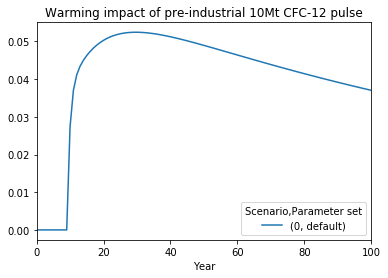

In [27]:
ONE_gas_results['T'].plot()
plt.title('Warming impact of pre-industrial 10Mt CFC-12 pulse')

### Blended concentration - emission runmode

While we do not advise running GIR in a "mixed" runmode due to the potential discontinuities when the model switches driver, it is possible to do so (though only switching from concentrations to emissions in that order)

In [28]:
blended_runmode_concs = return_empty_emissions(start_year=0,end_year=100)
blended_runmode_emms = return_empty_emissions(start_year=100,end_year=200)

blended_runmode_concs.loc[:] += get_gas_parameter_defaults().loc['PI_conc'].values.flatten()
blended_runmode_concs.loc[50] += [200,0,0]

blended_runmode_emms.loc[:] += [0,100,0]

blended_runmode_results = run_GIR(concentrations_in=blended_runmode_concs,emissions_in=blended_runmode_emms)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 independent thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 0.0 and 200.0...


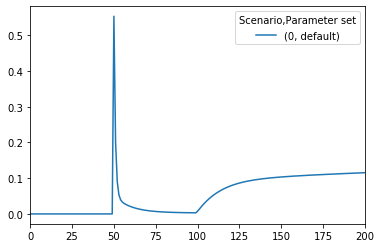

In [29]:
blended_runmode_results['T'].plot()

Test          
     CO2  CH4  N2O
0    0.0  0.0  0.0
1    0.0  0.0  0.0
2    0.0  0.0  0.0
3    0.0  0.0  0.0
4    0.0  0.0  0.0
5    0.0  0.0  0.0
6    0.0  0.0  0.0
7    0.0  0.0  0.0
8    0.0  0.0  0.0
9    0.0  0.0  0.0
10   0.0  0.0  0.0
11   0.0  0.0  0.0
12   0.0  0.0  0.0
13   0.0  0.0  0.0
14   0.0  0.0  0.0
15   0.0  0.0  0.0
16   0.0  0.0  0.0
17   0.0  0.0  0.0
18   0.0  0.0  0.0
19   0.0  0.0  0.0
20   0.0  0.0  0.0
21   0.0  0.0  0.0
22   0.0  0.0  0.0
23   0.0  0.0  0.0
24   0.0  0.0  0.0
25   0.0  0.0  0.0
26   0.0  0.0  0.0
27   0.0  0.0  0.0
28   0.0  0.0  0.0
29   0.0  0.0  0.0
..   ...  ...  ...
71   0.0  0.0  0.0
72   0.0  0.0  0.0
73   0.0  0.0  0.0
74   0.0  0.0  0.0
75   0.0  0.0  0.0
76   0.0  0.0  0.0
77   0.0  0.0  0.0
78   0.0  0.0  0.0
79   0.0  0.0  0.0
80   0.0  0.0  0.0
81   0.0  0.0  0.0
82   0.0  0.0  0.0
83   0.0  0.0  0.0
84   0.0  0.0  0.0
85   0.0  0.0  0.0
86   0.0  0.0  0.0
87   0.0  0.0  0.0
88   0.0  0.0  0.0
89   0.0  0.0  0.0
90   0.0  0.0  0.0
91   0.0  0.0  0.0
92   0.0  0.0  0.0
93   0.0  0.0  0.0
94   0.0  0.0  0.0
95   0.0  0.0  0.0
96   0.0  0.0  0.0
97   0.0  0.0  0.0
98   0.0  0.0  0.0
99   0.0  0.0  0.0
100  0.0  0.0  0.0

[101 rows x 3 columns]